### These are what I did:
- Try changing the weights for the style, content, and denoising.
- Use different weights for the content and style layers.
- Try using other layers in the model.
- Use several style images.

In [3]:
import tensorflow as tf
import numpy as np
import scipy.io
import os
import matplotlib.pyplot as plt
from scipy.misc import imread
from libs import utils
import os
content_directory = 'contents/'
style_directory = 'styles/'

# This is the directory to store the final stylized images
output_directory = 'image_output/'
if not os.path.exists(output_directory):
  os.makedirs(output_directory)

# This is the directory to store the half-done images during the training.
checkpoint_directory = 'checkpoint_output/'
if not os.path.exists(checkpoint_directory):
  os.makedirs(checkpoint_directory)

content_path = os.path.join(content_directory, 'flower.jpg')

#style_path = os.path.join(style_directory, 'sg.png')
style_path = os.path.join(style_directory, 'fractal_stained_glass.png')


In [5]:
content_image = utils.imread(content_path)

# You can pass several style images as a list, but let's use just one for now.
style_images = [utils.imread(style_path)]

In [6]:
import tensorflow as tf
import numpy as np
import scipy.io
import os

VGG_MEAN = [103.939, 116.779, 123.68]

VGG19_LAYERS = (
  'conv1_1', 'relu1_1', 'conv1_2', 'relu1_2', 'pool1',

  'conv2_1', 'relu2_1', 'conv2_2', 'relu2_2', 'pool2',

  'conv3_1', 'relu3_1', 'conv3_2', 'relu3_2', 'conv3_3',
  'relu3_3', 'conv3_4', 'relu3_4', 'pool3',

  'conv4_1', 'relu4_1', 'conv4_2', 'relu4_2', 'conv4_3',
  'relu4_3', 'conv4_4', 'relu4_4', 'pool4',

  'conv5_1', 'relu5_1', 'conv5_2', 'relu5_2', 'conv5_3',
'relu5_3', 'conv5_4', 'relu5_4'
)


def net_preloaded(input_image, pooling):
  data_dict = np.load('libs/vgg19.npy', encoding='latin1').item()
  net = {}
  current = input_image
  for i, name in enumerate(VGG19_LAYERS):
    kind = name[:4]
    if kind == 'conv':
      kernels = get_conv_filter(data_dict, name)
      # kernels = np.transpose(kernels, (1, 0, 2, 3))

      bias = get_bias(data_dict, name)
      # matconvnet: weights are [width, height, in_channels, out_channels]
      # tensorflow: weights are [height, width, in_channels, out_channels]

      # bias = bias.reshape(-1)
      current = conv_layer(current, kernels, bias)
    elif kind == 'relu':
      current = tf.nn.relu(current)
    elif kind == 'pool':
      current = pool_layer(current, pooling)

    net[name] = current

  assert len(net) == len(VGG19_LAYERS)
  return net

def conv_layer(input, weights, bias):
  conv = tf.nn.conv2d(input, weights, strides=(1, 1, 1, 1), padding='SAME')
  return tf.nn.bias_add(conv, bias)


def pool_layer(input, pooling):
  if pooling == 'avg':
    return tf.nn.avg_pool(input, ksize=(1, 2, 2, 1), strides=(1, 2, 2, 1),
            padding='SAME')
  else:
    return tf.nn.max_pool(input, ksize=(1, 2, 2, 1), strides=(1, 2, 2, 1),
            padding='SAME')

# before we feed the image into the network, we preprocess it by 
# extracting the mean_pixel from it.
def preprocess(image):
  return image - VGG_MEAN

# remember to unprocess it before you plot it out and save it.
def unprocess(image):
  return image + VGG_MEAN

def get_conv_filter(data_dict, name):
  return tf.constant(data_dict[name][0], name="filter")

def get_bias(data_dict, name):
  return tf.constant(data_dict[name][1], name="biases")

In [7]:
import tensorflow as tf
import numpy as np
from functools import reduce
from PIL import Image

# feel free to try different layers
CONTENT_LAYERS = ('relu4_2', 'relu5_2')
STYLE_LAYERS = ('relu1_1', 'relu2_1', 'relu3_1', 'relu4_1', 'relu5_1')

VGG_MEAN = [103.939, 116.779, 123.68]

def stylize(content, styles, network_path='libs/imagenet-vgg-verydeep-19.mat',
            iterations=1000, content_weight=5e0, content_weight_blend=0.5, style_weight=5e2,
            style_layer_weight_exp=1,style_blend_weights=None, tv_weight=100,
            learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-08, pooling='avg',
            print_iterations=100, checkpoint_iterations=100, checkpoint_path=None,
            output_path=None):


  shape = (1,) + content.shape                             #content image shape : (1,433,770,3)
  style_shapes = [(1,) + style.shape for style in styles]  #style image shape : (1,600,800,3)
  content_features = {}
  style_features = [{} for _ in styles]


  # scale the importance of each style layers according to their depth. 
  # (deeper layers are more important if style_layers_weights > 1 (default = 1))
  layer_weight = 1.0
  style_layers_weights = {}                                # weight for different network layers
  for style_layer in STYLE_LAYERS:
    style_layers_weights[style_layer] = layer_weight       #'relu1_1','relu2_1',...,'relu5_1'
    layer_weight *= style_layer_weight_exp                 # 1.0


  # normalize style layer weights
  layer_weights_sum = 0
  for style_layer in STYLE_LAYERS:                         #'relu1_1',..., 'relu5_1'
    layer_weights_sum += style_layers_weights[style_layer] # 5.0
  for style_layer in STYLE_LAYERS:
    style_layers_weights[style_layer] /= layer_weights_sum


  # FEATURE MAPS FROM CONTENT IMAGE
  # compute the feature map of the content image by feeding it into the network
  #the output net contains the features of each content layer
  g = tf.Graph()
  with g.as_default(), tf.Session() as sess:
    image = tf.placeholder('float', shape=shape)

    net = net_preloaded(image, pooling)             # {'conv1_1':Tensor,relu1_1:Tensor...}
    content_pre = np.array([preprocess(content)])   # (1,433,770,3) subtract the mean pixel
    for layer in CONTENT_LAYERS:                    #'relu4_2', 'relu5_2'
      content_features[layer] = net[layer].eval(feed_dict={image: content_pre})


  # FEATURE MAPS (GRAM MATRICES) FROM STYLE IMAGE
  # compute style features of the style image by feeding it into the network
  # and calculate the gram matrix
  for i in range(len(styles)):
    g = tf.Graph()
    with g.as_default(), tf.Session() as sess:
      image = tf.placeholder('float', shape=style_shapes[i])
      net = net_preloaded(image, pooling)
      style_pre = np.array([preprocess(styles[i])])
      for layer in STYLE_LAYERS:              #'relu1_1', 'relu2_1',..., 'relu5_1'
        features = net[layer].eval(feed_dict={image: style_pre})  # relu_1:(1,600,800,64)
        features = np.reshape(features, (-1, features.shape[3]))  # (480000, 64)
        gram = np.matmul(features.T, features) / features.size    # (64,64)
        style_features[i][layer] = gram


  # make stylized image using backpropogation
  with tf.Graph().as_default():

    # Generate a random image (the output image) with the same shape as the content image
    initial = tf.random_normal(shape) * 0.256
    image = tf.Variable(initial)
    net = net_preloaded(image, pooling)


    # CONTENT LOSS
    # we can adjust the weight of each content layers
    # content_weight_blend is the ratio of two used content layers in this example
    content_layers_weights = {}
    content_layers_weights['relu5_2'] = content_weight_blend
    content_layers_weights['relu4_2'] = 1.0 - content_weight_blend

    content_loss = 0
    content_losses = []
    for content_layer in CONTENT_LAYERS:
      # Use MSE as content losses
      # content weight is the coefficient for content loss
      content_losses.append(content_layers_weights[content_layer] * content_weight *
              (2 * tf.nn.l2_loss(net[content_layer] - content_features[content_layer]) /
              content_features[content_layer].size))
    content_loss += reduce(tf.add, content_losses)



    # STYLE LOSS
    # We can specify different weight for different style images
    # style_layers_weights => weight for different network layers
    # style_blend_weights => weight between different style images

    if style_blend_weights is None:
      style_blend_weights = [1.0/len(style_images) for _ in style_images]
    else:
      total_blend_weight = sum(style_blend_weights)
      # normalization
      style_blend_weights = [weight/total_blend_weight
                             for weight in style_blend_weights]


    style_loss = 0
    # iterate to calculate style loss with multiple style images
    for i in range(len(styles)):
      style_losses = []
      for style_layer in STYLE_LAYERS:             # e.g. relu1_1
        layer = net[style_layer]                   # relu1_1 of output image:(1,433,770,64)
        _, height, width, number = map(lambda i: i.value, layer.get_shape())
        size = height * width * number
        feats = tf.reshape(layer, (-1, number))    # (333410,64)

        # Gram matrix for the features in relu1_1 of the output image.
        gram = tf.matmul(tf.transpose(feats), feats) / size
        # Gram matrix for the features in relu1_1 of the style image
        style_gram = style_features[i][style_layer]

        # Style loss is the MSE for the difference of the 2 Gram matrices
        style_losses.append(style_layers_weights[style_layer] * 2 *
                            tf.nn.l2_loss(gram - style_gram) / style_gram.size)
      style_loss += style_weight * style_blend_weights[i] * reduce(tf.add, style_losses)


    # TOTAL VARIATION LOSS  
    # Total variation denoising to do smoothing; cost to penalize neighboring pixel
    # not used by the original paper by Gatys et al
    # According to the paper Mahendran, Aravindh, and Andrea Vedaldi. "Understanding deep 
    # image representations by inverting them."
    # Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition. 2015.
    tv_y_size = _tensor_size(image[:,1:,:,:])
    tv_x_size = _tensor_size(image[:,:,1:,:])
    tv_loss = tv_weight * 2 * (
      (tf.nn.l2_loss(image[:,1:,:,:] - image[:,:shape[1]-1,:,:]) /
          tv_y_size) +
      (tf.nn.l2_loss(image[:,:,1:,:] - image[:,:,:shape[2]-1,:]) /
          tv_x_size))


    #OVERALL LOSS
    loss = content_loss + style_loss + tv_loss

    train_step = tf.train.AdamOptimizer(learning_rate, beta1, beta2, epsilon).minimize(loss)

    def print_progress():
      print('     iteration: %d\n' % i)
      print('  content loss: %g\n' % content_loss.eval())
      print('    style loss: %g\n' % style_loss.eval())
      print('       tv loss: %g\n' % tv_loss.eval())
      print('    total loss: %g\n' % loss.eval())

    def imsave(path, img):
      img = np.clip(img, 0, 255).astype(np.uint8)
      Image.fromarray(img).save(path, quality=95)



    # TRAINING
    best_loss = float('inf')
    best = None

    with tf.Session() as sess:

      sess.run(tf.global_variables_initializer())

      if (print_iterations and print_iterations != 0):
        print_progress()

      for i in range(iterations):

        train_step.run()

        last_step = (i == iterations - 1)
        if last_step or (print_iterations and i % print_iterations == 0):
          print_progress()

        # store output and checkpoint images
        if (checkpoint_iterations and i % checkpoint_iterations == 0) or last_step:
          this_loss = loss.eval()
          if this_loss < best_loss:
            best_loss = this_loss
            best = image.eval()

          img_out = unprocess(best.reshape(shape[1:]))

          output_file = None
          if not last_step:
            if checkpoint_path:
                output_file = checkpoint_path % i
          else:
            output_file = output_path

          if output_file:
            imsave(output_file, img_out)

  print("finish stylizing.")



def _tensor_size(tensor):
  from operator import mul
  return reduce(mul, (d.value for d in tensor.get_shape()), 1)

# Content--Hydrangea

/home/chen/anaconda3/envs/tensorflow/lib/python3.5/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.


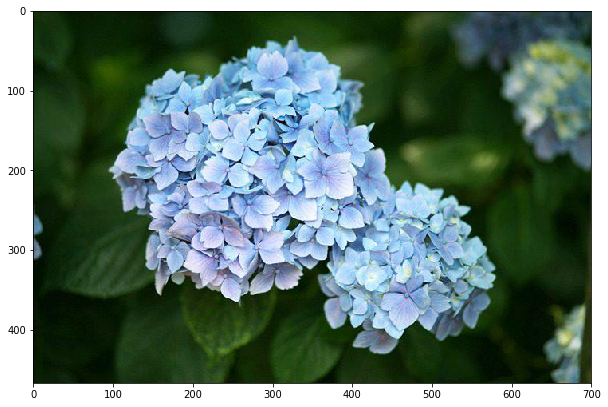

In [6]:
t1 = imread('contents/flower.jpg')
plt.figure(1, figsize=(10,10))
plt.imshow(t1)
plt.show()

# Style1--steined glass

/home/chen/anaconda3/envs/tensorflow/lib/python3.5/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.


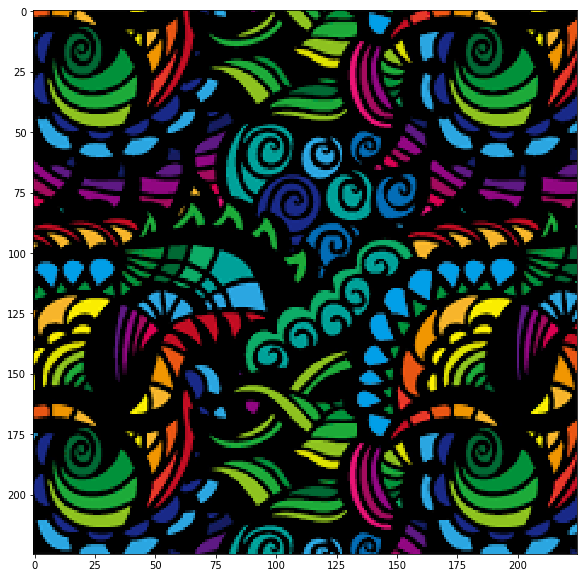

In [7]:
t = imread('styles/sg.png')
plt.figure(1, figsize=(10,10))
plt.imshow(t)
plt.show()

# Style2--steined glass with another pattern

/home/chen/anaconda3/envs/tensorflow/lib/python3.5/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.


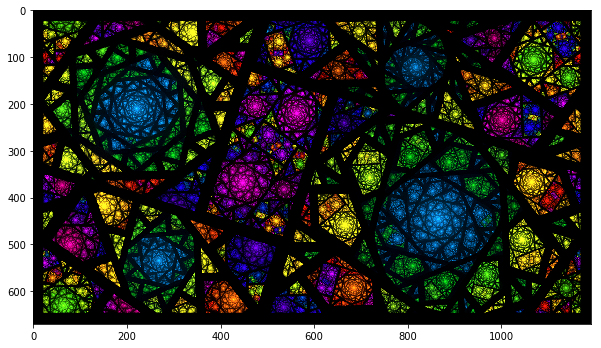

In [8]:
t = imread('styles/fractal_stained_glass.png')
plt.figure(1, figsize=(10,10))
plt.imshow(t)
plt.show()

### First, we use content layer of relu4_2 and apply style1.

In [5]:
#CONTENT_LAYERS = ('relu4_2')
#STYLE_LAYERS = ('relu1_1', 'relu2_1', 'relu3_1', 'relu4_1', 'relu5_1')

checkpoint_path='checkpoint_output/flower-sg-%d.jpg'
output_path='image_output/flower-sg-tvweight-100.jpg'

stylize(content_image, style_images, iterations=1000,
        content_weight=5e0, content_weight_blend=1, style_weight=5e2,
        style_layer_weight_exp=1, style_blend_weights=None, tv_weight=100,
        learning_rate=1e1, beta1=0.9, beta2=0.999, epsilon=1e-08, pooling='avg',
        print_iterations=100, checkpoint_iterations=100, checkpoint_path=checkpoint_path,
        output_path=output_path)

     iteration: 0

  content loss: 430680

    style loss: 4.19459e+07

       tv loss: 26.2432

    total loss: 4.23766e+07

     iteration: 0

  content loss: 403980

    style loss: 4.03364e+07

       tv loss: 13793.9

    total loss: 4.07541e+07

     iteration: 100

  content loss: 1.02351e+06

    style loss: 402966

       tv loss: 230804

    total loss: 1.65728e+06

     iteration: 200

  content loss: 883391

    style loss: 173455

       tv loss: 180277

    total loss: 1.23712e+06

     iteration: 300

  content loss: 809658

    style loss: 140960

       tv loss: 168166

    total loss: 1.11878e+06

     iteration: 400

  content loss: 767754

    style loss: 132956

       tv loss: 164469

    total loss: 1.06518e+06

     iteration: 500

  content loss: 742077

    style loss: 129128

       tv loss: 162695

    total loss: 1.0339e+06

     iteration: 600

  content loss: 725041

    style loss: 127534

       tv loss: 161651

    total loss: 1.01423e+06

     iterati

### Now here's the result

/home/chen/anaconda3/envs/tensorflow/lib/python3.5/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.


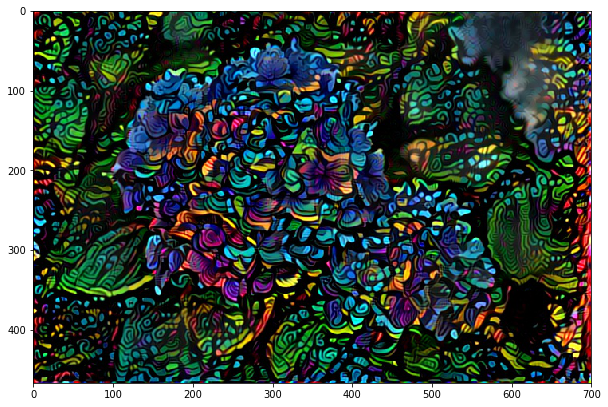

In [9]:
t = imread('image_output/flower-sg-tvweight-100.jpg')
plt.figure(1, figsize=(10,10))
plt.imshow(t)
plt.show()

### Then, we apply another style with different pattern to the same content layer(relu4_2)

In [5]:
#CONTENT_LAYERS = ('relu4_2')
#STYLE_LAYERS = ('relu1_1', 'relu2_1', 'relu3_1', 'relu4_1', 'relu5_1')

checkpoint_path='checkpoint_output/flower-sg2-%d.jpg'
output_path='image_output/flower-sg2-tvweight-100.jpg'

stylize(content_image, style_images, iterations=1000,
        content_weight=5e0, content_weight_blend=1, style_weight=5e2,
        style_layer_weight_exp=1, style_blend_weights=None, tv_weight=100,
        learning_rate=1e1, beta1=0.9, beta2=0.999, epsilon=1e-08, pooling='avg',
        print_iterations=100, checkpoint_iterations=100, checkpoint_path=checkpoint_path,
        output_path=output_path)

     iteration: 0

  content loss: 430718

    style loss: 1.57253e+07

       tv loss: 26.282

    total loss: 1.61561e+07

     iteration: 0

  content loss: 404969

    style loss: 1.48845e+07

       tv loss: 14433.8

    total loss: 1.53039e+07

     iteration: 100

  content loss: 595980

    style loss: 270514

       tv loss: 78196.1

    total loss: 944690

     iteration: 200

  content loss: 476721

    style loss: 212988

       tv loss: 59364.7

    total loss: 749074

     iteration: 300

  content loss: 455917

    style loss: 143978

       tv loss: 57408.4

    total loss: 657303

     iteration: 400

  content loss: 461486

    style loss: 280506

       tv loss: 61336.3

    total loss: 803329

     iteration: 500

  content loss: 461140

    style loss: 241405

       tv loss: 58828.3

    total loss: 761373

     iteration: 600

  content loss: 414666

    style loss: 114949

       tv loss: 52373

    total loss: 581988

     iteration: 700

  content loss: 416150

### Same content layer but different style

/home/chen/anaconda3/envs/tensorflow/lib/python3.5/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.


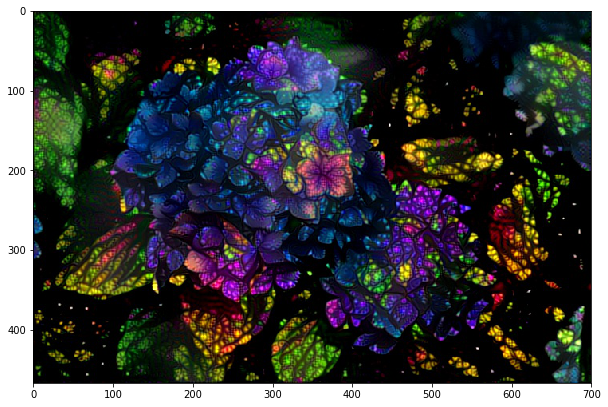

In [12]:
t = imread('image_output/flower-sg2-tvweight-100.jpg')
plt.figure(1, figsize=(10,10))
plt.imshow(t)
plt.show()

### Different weights of content, style and denoising in the loss function

In [5]:
CONTENT_LAYERS = ('relu4_2')
STYLE_LAYERS = ('relu1_1', 'relu2_1', 'relu3_1', 'relu4_1', 'relu5_1')

checkpoint_path='checkpoint_output/flower-sg2-%d.jpg'
output_path='image_output/flower-sg2-change-weight.jpg'

stylize(content_image, style_images, iterations=1000,
        content_weight=10, content_weight_blend=1.0, style_weight=1000,
        style_layer_weight_exp=1, style_blend_weights=None, tv_weight=10,
        learning_rate=1e1, beta1=0.9, beta2=0.999, epsilon=1e-08, pooling='avg',
        print_iterations=100, checkpoint_iterations=100, checkpoint_path=checkpoint_path,
        output_path=output_path)

     iteration: 0

  content loss: 861395

    style loss: 3.14506e+07

       tv loss: 2.61817

    total loss: 3.2312e+07

     iteration: 0

  content loss: 810496

    style loss: 2.97741e+07

       tv loss: 1446.5

    total loss: 3.0586e+07

     iteration: 100

  content loss: 1.17762e+06

    style loss: 681530

       tv loss: 19580.1

    total loss: 1.87873e+06

     iteration: 200

  content loss: 948503

    style loss: 250725

       tv loss: 14386.6

    total loss: 1.21361e+06

     iteration: 300

  content loss: 911852

    style loss: 205744

       tv loss: 13018.9

    total loss: 1.13062e+06

     iteration: 400

  content loss: 912406

    style loss: 430761

       tv loss: 12589.1

    total loss: 1.35576e+06

     iteration: 500

  content loss: 869461

    style loss: 197310

       tv loss: 11857.5

    total loss: 1.07863e+06

     iteration: 600

  content loss: 872502

    style loss: 348395

       tv loss: 11585.1

    total loss: 1.23248e+06

     ite

### Same content layer but different weights in loss function
Increasing the weight on style shows more details in the result image, but it is much noisy compared to previous image.

/home/chen/anaconda3/envs/tensorflow/lib/python3.5/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.


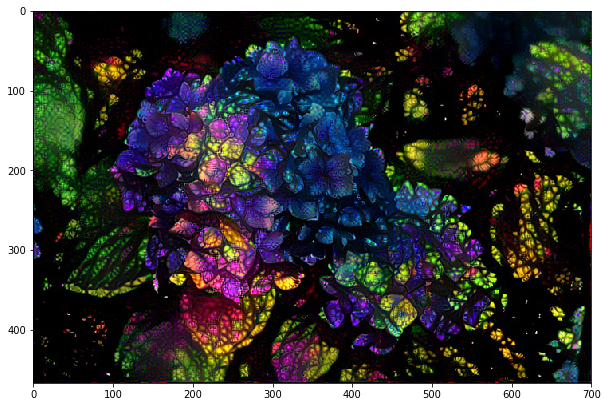

In [13]:
t = imread('image_output/flower-sg2-change-weight.jpg')
plt.figure(1, figsize=(10,10))
plt.imshow(t)
plt.show()

### Different weights for the content and style layers
Setting content_weight_blend=0.5 would blend 'relu4_2' and 'relu5_2'.

Also, we set serveral weights to different layer of style

In [5]:
#CONTENT_LAYERS = ('relu4_2', 'relu5_2')
#STYLE_LAYERS = ('relu1_1', 'relu2_1', 'relu3_1', 'relu4_1', 'relu5_1')

checkpoint_path='checkpoint_output/flower-sg2-%d.jpg'
output_path='image_output/flower-sg2-content-blend-0.5-stylew.jpg'

stylize(content_image, style_images, iterations=1000,
        content_weight=5e0, content_weight_blend=0.5, style_weight=5e2,
        style_layer_weight_exp=1, style_blend_weights=[1,2,3,4,5], tv_weight=100,
        learning_rate=1e1, beta1=0.9, beta2=0.999, epsilon=1e-08, pooling='avg',
        print_iterations=100, checkpoint_iterations=100, checkpoint_path=checkpoint_path,
        output_path=output_path)

     iteration: 0

  content loss: 215590

    style loss: 1.04835e+06

       tv loss: 26.2279

    total loss: 1.26397e+06

     iteration: 0

  content loss: 201426

    style loss: 994616

       tv loss: 14693.6

    total loss: 1.21074e+06

     iteration: 100

  content loss: 116682

    style loss: 79638.9

       tv loss: 36018.6

    total loss: 232340

     iteration: 200

  content loss: 109339

    style loss: 62002.4

       tv loss: 30730.6

    total loss: 202072

     iteration: 300

  content loss: 106614

    style loss: 58243.8

       tv loss: 29413.1

    total loss: 194271

     iteration: 400

  content loss: 105330

    style loss: 58354.1

       tv loss: 29298.4

    total loss: 192982

     iteration: 500

  content loss: 102333

    style loss: 57846.8

       tv loss: 28571.3

    total loss: 188751

     iteration: 600

  content loss: 102768

    style loss: 57211.8

       tv loss: 28861.7

    total loss: 188841

     iteration: 700

  content loss: 10

### Different weights for the content and style layers
The output looks more similar to original content, but some regions are blurred due to content and style blend.

/home/chen/anaconda3/envs/tensorflow/lib/python3.5/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.


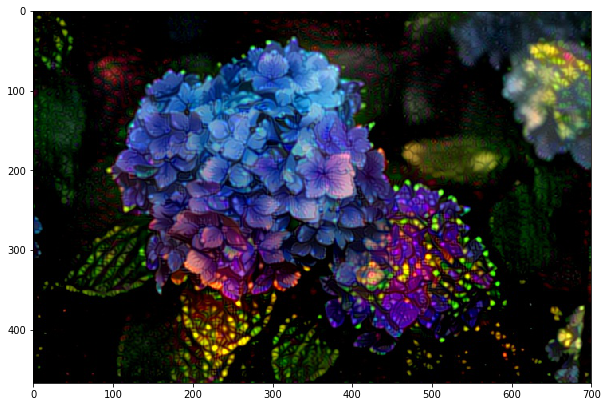

In [14]:
t = imread('image_output/flower-sg2-content-blend-0.5-stylew.jpg')
plt.figure(1, figsize=(10,10))
plt.imshow(t)
plt.show()

### Next, we change to use different content layer(relu5_2)

In [8]:
#CONTENT_LAYERS = ('relu5_2')
#STYLE_LAYERS = ('relu1_1', 'relu2_1', 'relu3_1', 'relu4_1', 'relu5_1')

checkpoint_path='checkpoint_output/flower-sg2-%d.jpg'
output_path='image_output/flower-sg2-change-layer.jpg'

stylize(content_image, style_images, iterations=1000,
        content_weight=5e0, content_weight_blend=1.0, style_weight=5e2,
        style_layer_weight_exp=1, style_blend_weights=None, tv_weight=100,
        learning_rate=1e1, beta1=0.9, beta2=0.999, epsilon=1e-08, pooling='avg',
        print_iterations=100, checkpoint_iterations=100, checkpoint_path=checkpoint_path,
        output_path=output_path)

     iteration: 0

  content loss: 482.658

    style loss: 1.57253e+07

       tv loss: 26.138

    total loss: 1.57258e+07

     iteration: 0

  content loss: 470.706

    style loss: 1.48627e+07

       tv loss: 14936.9

    total loss: 1.48781e+07

     iteration: 100

  content loss: 950.84

    style loss: 195780

       tv loss: 74758.9

    total loss: 271489

     iteration: 200

  content loss: 1000.99

    style loss: 51945.9

       tv loss: 52752.7

    total loss: 105700

     iteration: 300

  content loss: 987.112

    style loss: 129101

       tv loss: 60902.7

    total loss: 190991

     iteration: 400

  content loss: 990.914

    style loss: 35437.6

       tv loss: 50203.7

    total loss: 86632.2

     iteration: 500

  content loss: 1006.35

    style loss: 246394

       tv loss: 61054.1

    total loss: 308454

     iteration: 600

  content loss: 1033.65

    style loss: 41796.6

       tv loss: 50620.4

    total loss: 93450.6

     iteration: 700

  conten

### Use another content layer
This content layer shows different feature map.

/home/chen/anaconda3/envs/tensorflow/lib/python3.5/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.


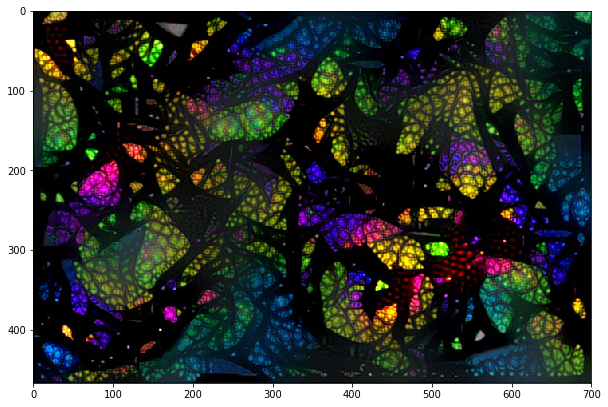

In [15]:
t = imread('image_output/flower-sg2-change-layer.jpg')
plt.figure(1, figsize=(10,10))
plt.imshow(t)
plt.show()